# Exercise 1: Linear Image Classifier

In this exercise you will implement a linear image classifier while getting familiar with `numpy` and the benefits of vectorized operations in Python. This exercise has 3 parts:

1. Python warmup: working with images, refresher on classes and objects.
2. Implementing loss functions, calculating gradients and implementing gradient descent.
3. Training and evaluating several classifiers.

## Submission guidelines:

Your zip should include the following files only:
```
- HW1.ipynb
- functions/
    - classifier.py
    - losses.py
```
Name the file `ex1_ID.zip` and do **not** include any additional directories or the data. 

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever instructed. 
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Do not change the functions we provided you. 
4. Write your functions in the instructed python modules only. All the logic you write is imported and used using this jupyter notebook. You are allowed to add functions as long as they are located in the python modules and are imported properly.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports are forbidden.
6. Your code must run without errors. Use `python 3` and `numpy 1.15.4` (configure a new environment as shown in the 2nd lecture if needed). Changes of the configuration we provided are at your own risk. Before submitting the exercise, restart the kernel and run the notebook from start to finish to make sure everything works. **Code that cannot run will not be tested.**
7. Write your own code. Cheating will not be tolerated. 
8. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support).

Q: What archive file format should you be using to compress the files and upload them to Moodle?

A: *.zip

Q: Should you run your code and make sure everything works just before you **zip** the files for submission? What will happen if your code cannot run?

A: ill fix it

Q: Should you include the data in your submission?

A: no

In [110]:
import os
import numpy as np
import matplotlib.pyplot as plt
from functions.classifier import LinearPerceptron
from functions.classifier import LogisticRegression
from functions.losses import perceptron_loss_vectorized
from functions.losses import perceptron_loss_naive
from functions.losses import binary_cross_entropy
from functions.losses import grad_check

# specify the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
import platform
print("Python version: ", platform.python_version())
print("Numpy version: ", np.__version__)

Python version:  3.7.1
Numpy version:  1.15.4


## Data preprocessing
The next few cells will download and extract CIFAR-10 into `datasets/cifar10/`. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class.

We have included several image processing functions. Notice the following in particular: we created an additional validation dataset you need to use for hyperparameter optimization (learning rate and L2 regularization). We subtracted the mean from all the images in order to ignore illumination conditions while keeping the content of the image. Next, we flattened the images from a tensor of shape (32x32x3) to a vector with 3072 features (pixel values) so we would be able to use a simple matrix multiplication. Finally, we concatenated each image vector with an additional feature to account for the bias. This is known as the bias trick. 

Make sure you understand this image processing pipeline before diving into the rest of the code.

In [112]:
from datasets import load_cifar10
URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
PATH = 'datasets/cifar10/' # the script will create required directories
load_cifar10.maybe_download_and_extract(URL, PATH)

Data has apparently already been downloaded and unpacked.


In [113]:
CIFAR10_PATH = os.path.join(PATH, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load_cifar10.load(CIFAR10_PATH) # load the entire data

# taking only two classes from the dataset
X_train = X_train[np.logical_or(y_train == 0, y_train == 1)]
y_train = y_train[np.logical_or(y_train == 0, y_train == 1)]
X_test = X_test[np.logical_or(y_test == 0, y_test == 1)]
y_test = y_test[np.logical_or(y_test == 0, y_test == 1)]

# define a splitting for the data
num_training = 10000
num_validation = 1000
num_testing = 1000

# add a validation dataset for hyperparameter optimization
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
mask = range(num_validation)
X_val = X_test[mask]
y_val = y_test[mask]
mask = range(num_validation, num_validation+num_testing)
X_test = X_test[mask]
y_test = y_test[mask]

# float64
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)
X_test = X_test.astype(np.float64)

# subtract the mean from all the images in the batch
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# flatten all the images in the batch (make sure you understand why this is needed)
X_train = np.reshape(X_train, newshape=(X_train.shape[0], -1))
X_val = np.reshape(X_val, newshape=(X_val.shape[0], -1)) 
X_test = np.reshape(X_test, newshape=(X_test.shape[0], -1)) 

# add a bias term to all images in the batch
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]) 
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]) 
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]) 

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
classes = ('plane', 'car')

(10000, 3073)
(1000, 3073)
(1000, 3073)


        plane           car           car         plane


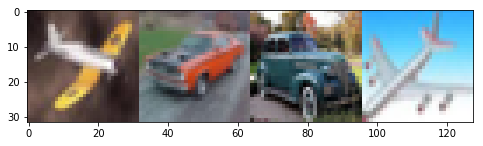

In [114]:
def get_batch(X, y, n):
    rand_items = np.random.randint(0, X.shape[0], size=n)
    images = X[rand_items]
    labels = y[rand_items]
    return X, y

def make_random_grid(x, y, n=4):
    rand_items = np.random.randint(0, x.shape[0], size=n)
    images = x[rand_items]
    labels = y[rand_items]
    grid = np.hstack((np.asarray((vec_2_img(i) + mean_image), dtype=np.int) for i in images))
    print(' '.join('%13s' % classes[labels[j]] for j in range(4)))
    return grid

def vec_2_img(x):
    x = np.reshape(x[:-1], (32, 32, 3))
    return x

X_batch, y_batch = get_batch(X_test, y_test, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

## Linear classifier: mapping images to scores

During this exercise, we will maintain a python class with basic functionality (such as training the model). the linear classifiers we will build (perceptron, logistic regression) will inherit some functionality from that class and will change several functions (such as the loss function, for example). Open the file `functions/classifier.py` and make sure you understand the code. You might find this [short classes in python tutorial](https://www.hackerearth.com/practice/python/object-oriented-programming/classes-and-objects-i/tutorial/) useful.

## Linear perceptron
Our first linear classifier will include a linear function that maps images to scores:

$$
f(x_i; W, b) = W\cdot x_i + b
$$

As you learned in class, this linear classifier takes an input image $x_i$ and outputs a class score. Your goal is to **learn** the parameters $W$ and $b$ to best classify the images according to the provided labels. The linear perceptron is set up so that the perceptron learn to map the correct class for each image such that it will have a score higher than the incorrect class. In this exercise, we will define our Linear perceptron to have two outputs - one outputs for each class.      

Open the file `functions/classifier.py`. The constructor of the `LinearPerceptron` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LinearPerceptron` class. **(2.5 points)**

In [317]:
classifier = LinearPerceptron(X_train, y_train)
y_pred = classifier.predict(X_test)

          car           car           car         plane


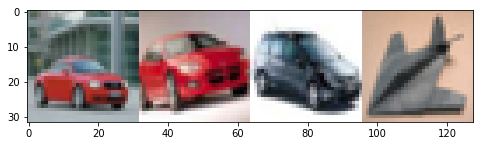

In [318]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

In [319]:
# predictions
print(' '.join('%13s' % classes[y_pred[j]] for j in range(4)))

          car         plane         plane           car


## Evaluation

Complete the class method `calc_accuracy` in `functions/classifier.py`. Explain why the accuracy on the training dataset (remember, the model is not trained yet) is around 50%. **(2.5 points)**

In [320]:
print("model accuracy: ", classifier.calc_accuracy(X_train, y_train))

model accuracy:  43.49


Your answer here: Because the model is not trained, we predict using the inital weights, which were init to all zeros, hence we will allways return the same prediction. which will fit the same class.
As we can see in the code provided in the notebook, we are predicting against 2 class with sample distribution of 50%
Our predict will always yeild the same answer (in our case plane) and we will have 50% accurecy rate (:

## Hinge loss (30 points)

Your code for this section will all be written inside `functions/losses.py`. In this section, we write and test code outside the classes for convenience. Notice the loss method for each class is just a call for the loss function written in `losses.py`. Once you are finished with implementation, everything should work.

First, complete the function `perceptron_loss_naive`. This function takes as input the weights, data, labels and a regularization term and outputs the calculated loss as a single number and the gradients with respect to W.

In [358]:
W = np.random.randn(3073, 2) * 0.0001

In [359]:
%%time
loss_naive, grad_naive = perceptron_loss_naive(W, X_val, y_val)
print ('loss: %f' % (loss_naive, ))
print ('grad_naive: {}'.format(grad_naive))

loss: 0.876360
grad_naive: [[-3.80192480e+00  3.80192480e+00]
 [-1.25378936e+01  1.25378936e+01]
 [-2.13818968e+01  2.13818968e+01]
 ...
 [-6.45989600e+00  6.45989600e+00]
 [-8.75763360e+00  8.75763360e+00]
 [ 8.00000000e-03 -8.00000000e-03]]
CPU times: user 107 ms, sys: 2.36 ms, total: 110 ms
Wall time: 58 ms


You are provided with a gradient checking function called `grad_check` in `functions/losses.py`. The following cells test your implementation of the loss value and gradient. Errors should be below $10^{-8}$.

In [360]:
loss, grad = perceptron_loss_naive(W, X_val, y_val)
f = lambda w: perceptron_loss_naive(w, X_val, y_val)[0]
grad_numerical = grad_check(f, W, grad)

numerical: -17.312988 analytic: -17.335218, relative error: 6.415905e-04
numerical: 4.884569 analytic: 4.884569, relative error: 5.581471e-12
numerical: -12.376239 analytic: -12.376239, relative error: 2.629319e-12
numerical: -9.203561 analytic: -9.195501, relative error: 4.380663e-04
numerical: 6.127868 analytic: 6.118628, relative error: 7.544655e-04
numerical: -21.928481 analytic: -21.928481, relative error: 2.225258e-13
numerical: 7.654907 analytic: 7.654907, relative error: 2.186361e-12
numerical: -21.173060 analytic: -21.157100, relative error: 3.770375e-04
numerical: -15.523392 analytic: -15.523392, relative error: 3.663508e-13
numerical: -20.457646 analytic: -20.457646, relative error: 1.016790e-12


Once your code works, complete the function `perceptron_loss_vectorized` and compare the results of the two functions using the cell below.

In [324]:
%%time

loss_vectorized, grad_vectorized = perceptron_loss_vectorized(W, X_val, y_val)
print ('loss: %f' % (loss, ))

difference = np.linalg.norm(grad_naive - grad_vectorized)
print ('difference: %f' % difference)

loss: 0.993930
difference: 0.000000
CPU times: user 19.5 ms, sys: 1.59 ms, total: 21.1 ms
Wall time: 10.2 ms


We have obtained an efficient function for loss and gradient calculation and we can now train our network. Complete the function `train` in `functions/classifier.py`. This function should be implemented in the `LinearClassifier` class. (**10 points**)

In [325]:
%%time
perceptron = LinearPerceptron(X_train, y_train)
loss_history = perceptron.train(X_train, y_train, 
                         learning_rate=1e-7,
                         num_iters=1500,
                         verbose=True)

loss = 1.1027253965246573
grad shape = (3073, 2)
W shape = (3073, 2)
iteration 0 / 1500: loss 1.102725
loss = 0.8854857111258159
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.7099742392832428
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.7549810621207647
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.6557296423672231
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.6784176815187059
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.6457588421694247
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.608413695023478
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5640074110587003
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.6048553275141124
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5982064267683427
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5921308877356484
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5902731939535016
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5982501571201054
grad shape = (3073, 2)
W shape = (3073, 2)
l

loss = 0.5359236176844344
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5202555961401393
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5104139431773155
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5759111594698374
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.524543987590003
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.47806719874038606
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.45272114897115984
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5153098325693639
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5514032285453563
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5383462249717731
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5270865696540907
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5077145615956004
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4044913446617018
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.45360013820135137
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5069910674787456
grad s

loss = 0.4862141001273559
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5974891873396503
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3786630919098787
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3542926857779062
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5109147102291925
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5133923026104015
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.47295390150056704
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4575499520225364
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.42200434404656034
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5593306280254605
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5023237479998935
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4693208810732261
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.47680941559428835
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5086398196415931
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.41419777463335417
grad

loss = 0.43349522162534443
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.46529354464115386
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5139445772432721
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5062365291784511
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4737175758819157
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4498604781545763
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.44562450899261663
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.43260052989231423
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.37703922980012167
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.46795484083285216
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.39544016605414556
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.39046290915595916
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.49150056554790117
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.41763345178061145
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.464251505583735

loss = 0.42430456954565043
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.48728515463338384
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.41831643329828355
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.47491836639000895
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.480553493996974
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3600191821454415
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.45275715475567524
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.38855322863680797
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4964268923969468
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4585720454164995
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3873453649390621
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.40025870250953793
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4292900177839566
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.45602019747555894
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.54243254624404
gra

loss = 0.42882987847325693
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.45075591032579526
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.39172434751247864
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4607046005380204
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.47472540595738044
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.43589664594517147
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.40113699294117544
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4287777964492163
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.40139323226252704
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4405472947230127
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4201018074256329
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4569885008692136
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4049700000639679
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5101388732059199
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3806839971779911
g

loss = 0.414617306087803
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.44439593344067746
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.36435514762502763
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.45282353397518976
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4238339578358303
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3903296236206144
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.41846741042053537
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4425885001871774
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4492937756902426
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.42824115098350274
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.46489451117322217
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.39930941999604996
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4288512359683272
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.38171608219416586
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.41395047713687844


loss = 0.49918122048856345
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4510430222060212
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.38541830059311766
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.49762128280828
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.378092537361447
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.466751518587227
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.387745301906277
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.39078395871036664
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.44474719811239494
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3560438739745853
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.34620232519447797
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4148794537135359
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.42172310232252785
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.42266630204643635
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4572560625286927
grad s

loss = 0.427792978875993
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3819296863884045
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4054008674410475
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5578286991010567
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.43397837799237626
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4324786543994981
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4323633224670889
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4361421543291797
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3802196769435418
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.32933962236425557
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.415736366677805
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4204028281382102
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.46316764674429495
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4281407563154678
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.49363938505150634
grad s

loss = 0.47533904017133466
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5019882120198598
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3967999543814551
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.47255348444922196
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.39609074264850974
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4312191250886078
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.427675935650047
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4665320221044691
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.42233510393606477
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.36223437785817564
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4267363042628067
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4628846095152822
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.42851240068137764
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.43948380201565646
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.49683768046456595
g

loss = 0.3973988220810736
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4310234008852241
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4186583411673655
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3970824951899352
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4161918238516122
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.43666141343161047
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4312646344347688
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.44416603758983697
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.36626147914300716
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.43753608910742403
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.45299289539464865
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3421369220371876
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3959134293263865
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.45005886704330594
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4801179971235181
gr

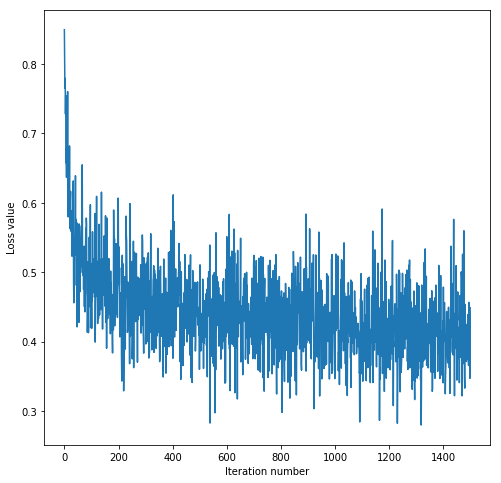

In [308]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [186]:
print("Training accuracy: ", perceptron.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", perceptron.calc_accuracy(X_test, y_test))

Training accuracy:  82.75
Testing accuracy:  82.5


## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset. 

Note: When changing the batch_size, change the number of iterations accordingly such that the number of epochs on the data stays roughly the same. A reasonable ratio is 600 iterations for a batch size of 200. 

If you are carful you should reach ~83% accuracy on the validation dataset.

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations. Finally, explain the results - what can you learn from the hyper parameters that yields the best results? Why do you think that is the case? **(5 points)**

In [18]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6]
batch_sizes = [1, 100, 200, 500, 10000]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_perceptron = None # The LinearPerceptron object that achieved the highest validation rate.

################################################################################
#                            START OF YOUR CODE                                #
################################################################################
num_of_samples = X_train.shape[0]
print(num_of_samples)
epochs = 200*600/num_of_samples
print(epochs)

for lr in learning_rates:
    for bs in batch_sizes:
        num_iters = int(epochs*num_of_samples/bs)
        print(num_iters)
        p = LinearPerceptron(X_train, y_train)
        _ = p.train(X_train, y_train, learning_rate=lr, num_iters=num_iters,batch_size=bs,verbose=True)
        val_accuracy = p.calc_accuracy(X_val, y_val)
        train_accuracy = p.calc_accuracy(X_train, y_train)
        
#         print('(lr, bs) = {}'.format((lr, bs)))
#         print('(val_accuracy,train_accuracy, best_val) = {}'.format((val_accuracy, train_accuracy, best_val)))

        if val_accuracy > best_val:
            best_val = val_accuracy
            best_perceptron = p
        results[(lr, bs)] = (train_accuracy,val_accuracy)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_perceptron.calc_accuracy(X_test, y_test)
print ('linear perceptron on raw pixels final test set accuracy: %f' % test_accuracy)

10000
12.0
120000
iteration 0 / 120000: loss 1.189933
iteration 100 / 120000: loss 0.000000
iteration 200 / 120000: loss 4.383662
iteration 300 / 120000: loss 2.554967
iteration 400 / 120000: loss 0.000000
iteration 500 / 120000: loss 1.489127
iteration 600 / 120000: loss 0.224333
iteration 700 / 120000: loss 0.000000
iteration 800 / 120000: loss 2.267194
iteration 900 / 120000: loss 3.603319
iteration 1000 / 120000: loss 0.000000
iteration 1100 / 120000: loss 0.000000
iteration 1200 / 120000: loss 2.458196
iteration 1300 / 120000: loss 0.000000
iteration 1400 / 120000: loss 0.000000
iteration 1500 / 120000: loss 0.000000
iteration 1600 / 120000: loss 1.813087
iteration 1700 / 120000: loss 2.549277
iteration 1800 / 120000: loss 1.207674
iteration 1900 / 120000: loss 0.000000
iteration 2000 / 120000: loss 5.856938
iteration 2100 / 120000: loss 4.254568
iteration 2200 / 120000: loss 0.000000
iteration 2300 / 120000: loss 0.000000
iteration 2400 / 120000: loss 0.000000
iteration 2500 / 12

iteration 20800 / 120000: loss 0.000000
iteration 20900 / 120000: loss 7.728128
iteration 21000 / 120000: loss 0.000000
iteration 21100 / 120000: loss 0.037480
iteration 21200 / 120000: loss 0.000000
iteration 21300 / 120000: loss 2.145562
iteration 21400 / 120000: loss 4.741962
iteration 21500 / 120000: loss 0.000000
iteration 21600 / 120000: loss 0.000000
iteration 21700 / 120000: loss 0.000000
iteration 21800 / 120000: loss 0.000000
iteration 21900 / 120000: loss 4.578201
iteration 22000 / 120000: loss 0.000000
iteration 22100 / 120000: loss 4.158442
iteration 22200 / 120000: loss 0.505011
iteration 22300 / 120000: loss 0.000000
iteration 22400 / 120000: loss 0.000000
iteration 22500 / 120000: loss 0.000000
iteration 22600 / 120000: loss 0.000000
iteration 22700 / 120000: loss 0.000000
iteration 22800 / 120000: loss 0.505800
iteration 22900 / 120000: loss 0.000000
iteration 23000 / 120000: loss 5.631189
iteration 23100 / 120000: loss 0.000000
iteration 23200 / 120000: loss 0.000000


iteration 41500 / 120000: loss 0.000000
iteration 41600 / 120000: loss 0.000000
iteration 41700 / 120000: loss 0.000000
iteration 41800 / 120000: loss 0.000000
iteration 41900 / 120000: loss 2.121417
iteration 42000 / 120000: loss 0.000000
iteration 42100 / 120000: loss 0.000000
iteration 42200 / 120000: loss 0.000000
iteration 42300 / 120000: loss 0.000000
iteration 42400 / 120000: loss 0.000000
iteration 42500 / 120000: loss 0.000000
iteration 42600 / 120000: loss 2.339386
iteration 42700 / 120000: loss 0.000000
iteration 42800 / 120000: loss 0.000000
iteration 42900 / 120000: loss 0.000000
iteration 43000 / 120000: loss 0.000000
iteration 43100 / 120000: loss 0.000000
iteration 43200 / 120000: loss 0.000000
iteration 43300 / 120000: loss 0.000000
iteration 43400 / 120000: loss 0.000000
iteration 43500 / 120000: loss 0.000000
iteration 43600 / 120000: loss 0.000000
iteration 43700 / 120000: loss 1.297782
iteration 43800 / 120000: loss 0.000000
iteration 43900 / 120000: loss 0.000000


iteration 62400 / 120000: loss 0.000000
iteration 62500 / 120000: loss 0.000000
iteration 62600 / 120000: loss 0.417521
iteration 62700 / 120000: loss 0.000000
iteration 62800 / 120000: loss 0.000000
iteration 62900 / 120000: loss 0.000000
iteration 63000 / 120000: loss 0.000000
iteration 63100 / 120000: loss 0.000000
iteration 63200 / 120000: loss 0.000000
iteration 63300 / 120000: loss 0.000000
iteration 63400 / 120000: loss 0.464037
iteration 63500 / 120000: loss 0.000000
iteration 63600 / 120000: loss 0.000000
iteration 63700 / 120000: loss 2.132313
iteration 63800 / 120000: loss 2.973153
iteration 63900 / 120000: loss 0.000000
iteration 64000 / 120000: loss 0.000000
iteration 64100 / 120000: loss 0.000000
iteration 64200 / 120000: loss 1.313898
iteration 64300 / 120000: loss 0.000000
iteration 64400 / 120000: loss 0.000000
iteration 64500 / 120000: loss 0.000000
iteration 64600 / 120000: loss 0.000000
iteration 64700 / 120000: loss 0.000000
iteration 64800 / 120000: loss 0.000000


iteration 83000 / 120000: loss 3.183947
iteration 83100 / 120000: loss 0.000000
iteration 83200 / 120000: loss 0.000000
iteration 83300 / 120000: loss 0.000000
iteration 83400 / 120000: loss 0.820024
iteration 83500 / 120000: loss 0.000000
iteration 83600 / 120000: loss 0.746052
iteration 83700 / 120000: loss 0.000000
iteration 83800 / 120000: loss 0.000000
iteration 83900 / 120000: loss 0.000000
iteration 84000 / 120000: loss 1.987129
iteration 84100 / 120000: loss 0.977997
iteration 84200 / 120000: loss 0.000000
iteration 84300 / 120000: loss 0.000000
iteration 84400 / 120000: loss 1.886728
iteration 84500 / 120000: loss 1.300303
iteration 84600 / 120000: loss 0.000000
iteration 84700 / 120000: loss 0.000000
iteration 84800 / 120000: loss 0.000000
iteration 84900 / 120000: loss 0.000000
iteration 85000 / 120000: loss 0.000000
iteration 85100 / 120000: loss 0.959568
iteration 85200 / 120000: loss 0.000000
iteration 85300 / 120000: loss 0.000000
iteration 85400 / 120000: loss 0.000000


iteration 103400 / 120000: loss 0.000000
iteration 103500 / 120000: loss 1.029932
iteration 103600 / 120000: loss 0.000000
iteration 103700 / 120000: loss 0.642286
iteration 103800 / 120000: loss 0.000000
iteration 103900 / 120000: loss 0.000000
iteration 104000 / 120000: loss 2.780785
iteration 104100 / 120000: loss 0.000000
iteration 104200 / 120000: loss 0.000000
iteration 104300 / 120000: loss 0.750355
iteration 104400 / 120000: loss 4.085876
iteration 104500 / 120000: loss 0.000000
iteration 104600 / 120000: loss 0.000000
iteration 104700 / 120000: loss 0.000000
iteration 104800 / 120000: loss 0.000000
iteration 104900 / 120000: loss 0.000000
iteration 105000 / 120000: loss 1.707787
iteration 105100 / 120000: loss 0.000000
iteration 105200 / 120000: loss 0.000000
iteration 105300 / 120000: loss 6.455247
iteration 105400 / 120000: loss 0.000000
iteration 105500 / 120000: loss 0.000000
iteration 105600 / 120000: loss 0.000000
iteration 105700 / 120000: loss 0.000000
iteration 105800

iteration 2700 / 120000: loss 0.000000
iteration 2800 / 120000: loss 0.000000
iteration 2900 / 120000: loss 0.000000
iteration 3000 / 120000: loss 0.000000
iteration 3100 / 120000: loss 0.000000
iteration 3200 / 120000: loss 0.000000
iteration 3300 / 120000: loss 0.000000
iteration 3400 / 120000: loss 0.000000
iteration 3500 / 120000: loss 0.000000
iteration 3600 / 120000: loss 0.000000
iteration 3700 / 120000: loss 0.000000
iteration 3800 / 120000: loss 0.000000
iteration 3900 / 120000: loss 0.000000
iteration 4000 / 120000: loss 0.000000
iteration 4100 / 120000: loss 0.000000
iteration 4200 / 120000: loss 6.373958
iteration 4300 / 120000: loss 0.000000
iteration 4400 / 120000: loss 0.000000
iteration 4500 / 120000: loss 0.000000
iteration 4600 / 120000: loss 0.000000
iteration 4700 / 120000: loss 0.000000
iteration 4800 / 120000: loss 111.566293
iteration 4900 / 120000: loss 0.000000
iteration 5000 / 120000: loss 0.000000
iteration 5100 / 120000: loss 0.000000
iteration 5200 / 120000

iteration 23400 / 120000: loss 0.000000
iteration 23500 / 120000: loss 209.508729
iteration 23600 / 120000: loss 0.000000
iteration 23700 / 120000: loss 0.000000
iteration 23800 / 120000: loss 35.347159
iteration 23900 / 120000: loss 0.000000
iteration 24000 / 120000: loss 0.000000
iteration 24100 / 120000: loss 8.649994
iteration 24200 / 120000: loss 0.000000
iteration 24300 / 120000: loss 0.000000
iteration 24400 / 120000: loss 0.000000
iteration 24500 / 120000: loss 0.000000
iteration 24600 / 120000: loss 0.000000
iteration 24700 / 120000: loss 0.000000
iteration 24800 / 120000: loss 24.574206
iteration 24900 / 120000: loss 0.000000
iteration 25000 / 120000: loss 0.000000
iteration 25100 / 120000: loss 0.000000
iteration 25200 / 120000: loss 0.000000
iteration 25300 / 120000: loss 0.000000
iteration 25400 / 120000: loss 0.000000
iteration 25500 / 120000: loss 0.000000
iteration 25600 / 120000: loss 0.000000
iteration 25700 / 120000: loss 0.000000
iteration 25800 / 120000: loss 0.000

iteration 44900 / 120000: loss 0.000000
iteration 45000 / 120000: loss 0.000000
iteration 45100 / 120000: loss 0.000000
iteration 45200 / 120000: loss 23.032252
iteration 45300 / 120000: loss 0.000000
iteration 45400 / 120000: loss 0.000000
iteration 45500 / 120000: loss 17.326093
iteration 45600 / 120000: loss 124.772201
iteration 45700 / 120000: loss 0.000000
iteration 45800 / 120000: loss 0.000000
iteration 45900 / 120000: loss 0.000000
iteration 46000 / 120000: loss 0.000000
iteration 46100 / 120000: loss 0.000000
iteration 46200 / 120000: loss 0.000000
iteration 46300 / 120000: loss 67.215918
iteration 46400 / 120000: loss 0.000000
iteration 46500 / 120000: loss 60.776533
iteration 46600 / 120000: loss 0.000000
iteration 46700 / 120000: loss 0.000000
iteration 46800 / 120000: loss 0.000000
iteration 46900 / 120000: loss 33.390565
iteration 47000 / 120000: loss 5.485418
iteration 47100 / 120000: loss 119.343456
iteration 47200 / 120000: loss 4.412457
iteration 47300 / 120000: loss 

iteration 66200 / 120000: loss 7.439800
iteration 66300 / 120000: loss 0.000000
iteration 66400 / 120000: loss 0.000000
iteration 66500 / 120000: loss 126.110739
iteration 66600 / 120000: loss 0.000000
iteration 66700 / 120000: loss 0.000000
iteration 66800 / 120000: loss 0.000000
iteration 66900 / 120000: loss 3.236604
iteration 67000 / 120000: loss 0.000000
iteration 67100 / 120000: loss 0.000000
iteration 67200 / 120000: loss 0.000000
iteration 67300 / 120000: loss 0.000000
iteration 67400 / 120000: loss 0.000000
iteration 67500 / 120000: loss 27.072714
iteration 67600 / 120000: loss 196.857036
iteration 67700 / 120000: loss 0.000000
iteration 67800 / 120000: loss 16.672490
iteration 67900 / 120000: loss 52.745485
iteration 68000 / 120000: loss 0.000000
iteration 68100 / 120000: loss 0.000000
iteration 68200 / 120000: loss 0.000000
iteration 68300 / 120000: loss 116.034262
iteration 68400 / 120000: loss 14.563620
iteration 68500 / 120000: loss 0.000000
iteration 68600 / 120000: loss

iteration 87500 / 120000: loss 46.860601
iteration 87600 / 120000: loss 82.476857
iteration 87700 / 120000: loss 0.000000
iteration 87800 / 120000: loss 0.000000
iteration 87900 / 120000: loss 0.000000
iteration 88000 / 120000: loss 82.365433
iteration 88100 / 120000: loss 0.000000
iteration 88200 / 120000: loss 0.000000
iteration 88300 / 120000: loss 0.000000
iteration 88400 / 120000: loss 0.000000
iteration 88500 / 120000: loss 0.000000
iteration 88600 / 120000: loss 0.000000
iteration 88700 / 120000: loss 0.000000
iteration 88800 / 120000: loss 0.000000
iteration 88900 / 120000: loss 0.000000
iteration 89000 / 120000: loss 0.000000
iteration 89100 / 120000: loss 0.000000
iteration 89200 / 120000: loss 0.000000
iteration 89300 / 120000: loss 0.000000
iteration 89400 / 120000: loss 0.000000
iteration 89500 / 120000: loss 32.148823
iteration 89600 / 120000: loss 0.000000
iteration 89700 / 120000: loss 0.000000
iteration 89800 / 120000: loss 0.000000
iteration 89900 / 120000: loss 0.000

iteration 108400 / 120000: loss 103.359355
iteration 108500 / 120000: loss 0.000000
iteration 108600 / 120000: loss 0.000000
iteration 108700 / 120000: loss 0.000000
iteration 108800 / 120000: loss 0.000000
iteration 108900 / 120000: loss 0.000000
iteration 109000 / 120000: loss 0.000000
iteration 109100 / 120000: loss 6.710851
iteration 109200 / 120000: loss 0.000000
iteration 109300 / 120000: loss 74.080961
iteration 109400 / 120000: loss 0.000000
iteration 109500 / 120000: loss 0.000000
iteration 109600 / 120000: loss 0.000000
iteration 109700 / 120000: loss 115.050349
iteration 109800 / 120000: loss 156.073274
iteration 109900 / 120000: loss 0.000000
iteration 110000 / 120000: loss 0.000000
iteration 110100 / 120000: loss 0.000000
iteration 110200 / 120000: loss 0.000000
iteration 110300 / 120000: loss 0.000000
iteration 110400 / 120000: loss 20.806888
iteration 110500 / 120000: loss 0.000000
iteration 110600 / 120000: loss 0.000000
iteration 110700 / 120000: loss 0.000000
iteratio

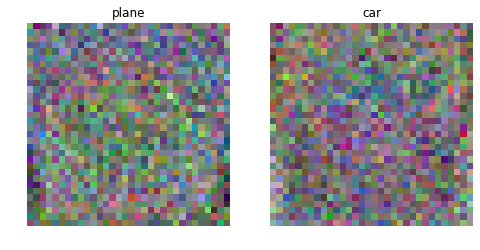

In [19]:
w = best_perceptron.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 2)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car']
for i in range(2):
    plt.subplot(1, 2, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

## Logistic regression

Another choice for a binary classifier is the binary logistic regression classifier. Unlike the perceptron which treats the outputs as uncalibrated and possibly difficult to interpret scores for each class, the binary logistic regression classifier gives a slightly more intuitive output in the form of normalized class probabilities. In this classifier, the function mapping $f(x_i; W, b) = W\cdot x_i + b$ stays unchanged but we now interpret these scores as the unnormalized log probabilities for each class and replace the hinge loss with a cross-entropy loss. In this exercise, we will define our binary logistic regression classifier to have one input.       

Open the file `functions/classifier.py`. The constructor of the `LogisticRegression` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LogisticRegression` class - remember you need to implement the sigmoid function before you can obtain predictions using your classifier. (**2.5 points**)

**Important note**: values passed to the `sigmoid` function can be arbitrarily large or small. When we take the exponent of such values, we might encounter extreme values that might *overflow*. This is known as numerical instability and you should always take care when you use exponent in your functions. 

In [309]:
logistic = LogisticRegression(X_train, y_train)
y_pred = logistic.predict(X_test)

        plane           car         plane         plane


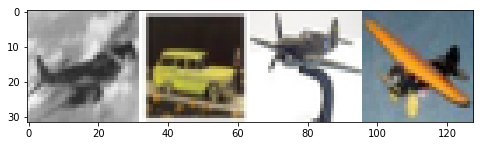

In [310]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

In [311]:
# predictions
print(' '.join('%13s' % classes[y_pred[j]] for j in range(4)))

        plane         plane         plane         plane


## Evaluation

Complete the class method `calc_accuracy` in the `LinearClassifier` located in `functions/classifier.py`. (**2.5 points**)

In [312]:
print("model accuracy: ", logistic.calc_accuracy(X_train, y_train))

model accuracy:  50.0


## Binary cross-entropy (30 points)

Your code for this section will all be written inside **functions/losses.py**. 

Complete the function `binary_cross_entropy` using vectorized code. This function takes as input the weights, data, labels and a regularization term and outputs the calculated loss as a single number and the gradients with respect to W. (**10 points**)

In [411]:
W = np.random.randn(3073, 1) * 0.0001

In [412]:
%%time
loss_naive, grad_naive = binary_cross_entropy(W, X_val, y_val)
print ('loss: %f' % (loss_naive, ))
# print ('grad_naive: {}'.format(grad_naive))

(1000, 1000)
(1000, 3073)
loss: 0.708376
CPU times: user 244 ms, sys: 7.04 ms, total: 251 ms
Wall time: 128 ms


In [413]:
loss, grad = binary_cross_entropy(W, X_val, y_val)
f = lambda w: binary_cross_entropy(w, X_val, y_val)[0]
grad_numerical = grad_check(f, W, grad)

(1000, 1000)
(1000, 3073)
(1000, 1000)
(1000, 3073)
(1000, 1000)
(1000, 3073)
numerical: -0.550561 analytic: 0.000000, relative error: 1.000000e+00
(1000, 1000)
(1000, 3073)
(1000, 1000)
(1000, 3073)
numerical: -1.709961 analytic: 0.000000, relative error: 1.000000e+00
(1000, 1000)
(1000, 3073)
(1000, 1000)
(1000, 3073)
numerical: 0.082836 analytic: 0.000000, relative error: 1.000000e+00
(1000, 1000)
(1000, 3073)
(1000, 1000)
(1000, 3073)
numerical: -1.005669 analytic: 0.000000, relative error: 1.000000e+00
(1000, 1000)
(1000, 3073)
(1000, 1000)
(1000, 3073)
numerical: 2.192949 analytic: 0.000000, relative error: 1.000000e+00
(1000, 1000)
(1000, 3073)
(1000, 1000)
(1000, 3073)
numerical: 0.166547 analytic: 0.000000, relative error: 1.000000e+00
(1000, 1000)
(1000, 3073)
(1000, 1000)
(1000, 3073)
numerical: 1.059781 analytic: 0.000000, relative error: 1.000000e+00
(1000, 1000)
(1000, 3073)
(1000, 1000)
(1000, 3073)
numerical: -0.429017 analytic: 0.000000, relative error: 1.000000e+00
(1

If implemented correctly, the training procedure you already implemented should work.

In [383]:
%%time
logistic = LogisticRegression(X_train, y_train)
loss_history = logistic.train(X_train, y_train, 
                         learning_rate=1e-7,
                         num_iters=1500,
                         verbose=True)

loss = 0.7114366077171346
grad shape = (3073, 1)
W shape = (3073, 1)
iteration 0 / 1500: loss 0.711437
loss = 0.7859031579356349
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 0.7475229705300964
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 1.0012608449547822
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 1.0045532750470771
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 0.8142792214605704
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 0.871091311838175
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 1.4648830497547574
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 1.4448360814456553
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 1.4972257198994094
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 1.8344871622864833
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 1.9036217477689883
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 1.8844873458970495
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 2.0924514729107186
grad shape = (3073, 1)
W shape = (3073, 1)
l

loss = 3.5668113416239904
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 3.979393962009688
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 3.9113078668294055
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 3.483289438789706
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 3.3374108352018528
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 3.6773198341162496
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 3.7489458148374992
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 3.5632702552084003
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 3.601709682820549
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 3.8198769432479383
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.091328009359252
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 3.92633248124292
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 3.8230288471374427
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 3.8518056913040346
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 3.6559584650262584
grad shape = (

/Users/danielbachar/Documents/IDC/ImageUnderstandingUsingDeepLearningIDC2019/HW1/functions/losses.py:173: RuntimeWarning: divide by zero encountered in log
  second = (1 - y) * np.log(1 - predictions)
/Users/danielbachar/Documents/IDC/ImageUnderstandingUsingDeepLearningIDC2019/HW1/functions/losses.py:173: RuntimeWarning: invalid value encountered in multiply
  second = (1 - y) * np.log(1 - predictions)


loss = 4.096471469473266
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.191770958142202
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.217909543410695
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.501002358031775
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.179645568443862
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.39411492070024
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 3.8007489857536734
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 3.718202918163662
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.284907559724705
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.543888657518532
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 3.9985470721879834
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.233984773488512
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 3.673797144878276
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.004139543022387
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 3.879754135095209
grad shape = (3073, 1)

loss = 4.083509273517744
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.980045846221089
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.6001135916277285
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.5647136422963275
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.215453022568666
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.269133776479399
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 3.883298038032795
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.234036802406006
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.783437454621702
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.50969910582811
grad shape = (3073, 1)
W shape = (3073

loss = 4.9672669001969245
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 5.133498207137039
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.9082001100476464
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 5.456309872142097
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
iteration 600 / 1500: loss nan
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 5.160268936110159
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)

loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.83254776151581
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = 4.659749602772112
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
l

loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (307

loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (307

loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (3073, 1)
W shape = (3073, 1)
loss = nan
grad shape = (307

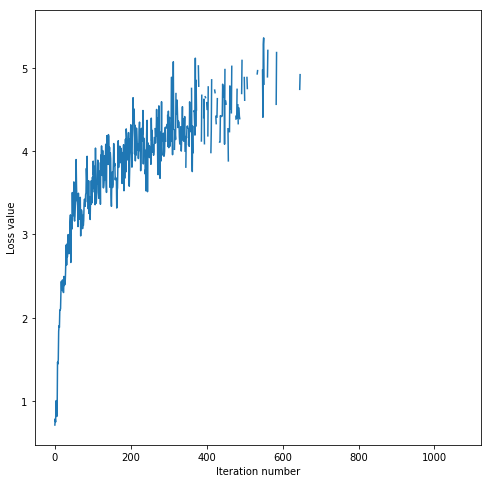

In [384]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [385]:
print("Training accuracy: ", logistic.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", logistic.calc_accuracy(X_test, y_test))

Training accuracy:  50.0
Testing accuracy:  50.7


## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset. 

Note: When changing the batch_size, change the number of iterations accordingly such that the number of epochs on the data stays roughly the same. A reasonable ratio is 600 iterations for a batch size of 200. 

If you are carful you should reach ~83% accuracy on the validation dataset.

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations. Finally, explain the results - what can you learn from the hyper parameters that yields the best results? Why do you think that is the case? **(5 points)**

In [390]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6]
batch_sizes = [1, 100, 200, 500, 1000, 10000]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_logistic = None # The LogisticRegression object that achieved the highest validation rate.

################################################################################
#                            START OF YOUR CODE                                #
################################################################################
num_of_samples = X_train.shape[0]
print(num_of_samples)
epochs = 200*600/num_of_samples
print(epochs)

for lr in learning_rates:
    for bs in batch_sizes:
        num_iters = int(epochs*num_of_samples/bs)
        print(num_iters)
        p = LogisticRegression(X_train, y_train)
        _ = p.train(X_train, y_train, learning_rate=lr, num_iters=num_iters,batch_size=bs,verbose=True)
        val_accuracy = p.calc_accuracy(X_val, y_val)
        train_accuracy = p.calc_accuracy(X_train, y_train)
        
        print('(lr, bs) = {}'.format((lr, bs)))
        print('(val_accuracy,train_accuracy, best_val) = {}'.format((val_accuracy, train_accuracy, best_val)))

        if val_accuracy > best_val:
            best_val = val_accuracy
            best_logistic = p
        results[(lr, bs)] = (train_accuracy,val_accuracy)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_perceptron.calc_accuracy(X_test, y_test)
print ('Binary logistic regression on raw pixels final test set accuracy: %f' % test_accuracy)

10000
12.0
120000
iteration 0 / 120000: loss 1.004117
iteration 100 / 120000: loss 1.385885
iteration 200 / 120000: loss 0.898638
iteration 300 / 120000: loss 0.996704
iteration 400 / 120000: loss 0.602308
iteration 500 / 120000: loss 0.439707
iteration 600 / 120000: loss 0.064007
iteration 700 / 120000: loss 0.336086
iteration 800 / 120000: loss 0.662169
iteration 900 / 120000: loss 0.415027
iteration 1000 / 120000: loss 1.647992
iteration 1100 / 120000: loss 2.358969
iteration 1200 / 120000: loss 0.034435
iteration 1300 / 120000: loss 0.001154
iteration 1400 / 120000: loss 2.151152
iteration 1500 / 120000: loss 1.201417
iteration 1600 / 120000: loss 1.067768
iteration 1700 / 120000: loss 3.712941
iteration 1800 / 120000: loss 0.173051
iteration 1900 / 120000: loss 1.181967
iteration 2000 / 120000: loss 1.238710
iteration 2100 / 120000: loss 0.044141
iteration 2200 / 120000: loss 0.264092
iteration 2300 / 120000: loss 0.263005
iteration 2400 / 120000: loss 0.007762
iteration 2500 / 12

iteration 21600 / 120000: loss 0.679962
iteration 21700 / 120000: loss 3.593249
iteration 21800 / 120000: loss 9.599600
iteration 21900 / 120000: loss 1.643526
iteration 22000 / 120000: loss 5.143871
iteration 22100 / 120000: loss 12.099370
iteration 22200 / 120000: loss 22.439149
iteration 22300 / 120000: loss 0.000304
iteration 22400 / 120000: loss 0.000597
iteration 22500 / 120000: loss 0.000019
iteration 22600 / 120000: loss 6.828051
iteration 22700 / 120000: loss 12.067527
iteration 22800 / 120000: loss 0.000570
iteration 22900 / 120000: loss 3.069308
iteration 23000 / 120000: loss 12.899122
iteration 23100 / 120000: loss 7.787991
iteration 23200 / 120000: loss 0.010115
iteration 23300 / 120000: loss 4.384481
iteration 23400 / 120000: loss 6.809950
iteration 23500 / 120000: loss 6.596993
iteration 23600 / 120000: loss 1.646462
iteration 23700 / 120000: loss 0.000004
iteration 23800 / 120000: loss 0.245184
iteration 23900 / 120000: loss 17.507823
iteration 24000 / 120000: loss 2.55

iteration 43500 / 120000: loss 2.293186
iteration 43600 / 120000: loss 15.444535
iteration 43700 / 120000: loss 2.363572
iteration 43800 / 120000: loss 10.794924
iteration 43900 / 120000: loss 10.289289
iteration 44000 / 120000: loss 0.000007
iteration 44100 / 120000: loss 12.248281
iteration 44200 / 120000: loss 3.211478
iteration 44300 / 120000: loss 4.034266
iteration 44400 / 120000: loss 0.467117
iteration 44500 / 120000: loss 2.768177
iteration 44600 / 120000: loss 7.308105
iteration 44700 / 120000: loss 17.374755
iteration 44800 / 120000: loss 0.023774
iteration 44900 / 120000: loss 5.965510
iteration 45000 / 120000: loss 0.002153
iteration 45100 / 120000: loss 21.822116
iteration 45200 / 120000: loss 18.956377
iteration 45300 / 120000: loss 1.165865
iteration 45400 / 120000: loss 5.661368
iteration 45500 / 120000: loss 13.138432
iteration 45600 / 120000: loss 5.830742
iteration 45700 / 120000: loss 19.783398
iteration 45800 / 120000: loss 0.629096
iteration 45900 / 120000: loss 

iteration 64400 / 120000: loss 0.001291
iteration 64500 / 120000: loss 0.030822
iteration 64600 / 120000: loss 19.241151
iteration 64700 / 120000: loss 9.279488
iteration 64800 / 120000: loss 9.498923
iteration 64900 / 120000: loss 15.332456
iteration 65000 / 120000: loss 0.409573
iteration 65100 / 120000: loss 0.000005
iteration 65200 / 120000: loss 4.262625
iteration 65300 / 120000: loss 0.000454
iteration 65400 / 120000: loss 6.718498
iteration 65500 / 120000: loss 20.974435
iteration 65600 / 120000: loss 25.124935
iteration 65700 / 120000: loss 4.526837
iteration 65800 / 120000: loss 13.105180
iteration 65900 / 120000: loss 0.030269
iteration 66000 / 120000: loss 1.635188
iteration 66100 / 120000: loss 8.293721
iteration 66200 / 120000: loss 0.000198
iteration 66300 / 120000: loss 0.718476
iteration 66400 / 120000: loss 18.395687
iteration 66500 / 120000: loss 2.519932
iteration 66600 / 120000: loss 0.000011
iteration 66700 / 120000: loss 6.299821
iteration 66800 / 120000: loss 22.

iteration 86000 / 120000: loss 20.247849
iteration 86100 / 120000: loss 0.021353
iteration 86200 / 120000: loss 0.000036
iteration 86300 / 120000: loss 0.674861
iteration 86400 / 120000: loss 0.916223
iteration 86500 / 120000: loss 4.512183
iteration 86600 / 120000: loss 30.760450
iteration 86700 / 120000: loss 17.506833
iteration 86800 / 120000: loss 5.033750
iteration 86900 / 120000: loss 1.828258
iteration 87000 / 120000: loss 5.551124
iteration 87100 / 120000: loss 13.086632
iteration 87200 / 120000: loss 2.768635
iteration 87300 / 120000: loss 17.738089
iteration 87400 / 120000: loss 0.625284
iteration 87500 / 120000: loss 0.000002
iteration 87600 / 120000: loss 0.000025
iteration 87700 / 120000: loss 6.073356
iteration 87800 / 120000: loss 29.890921
iteration 87900 / 120000: loss 13.917078
iteration 88000 / 120000: loss 7.370102
iteration 88100 / 120000: loss 14.096098
iteration 88200 / 120000: loss 0.007263
iteration 88300 / 120000: loss 3.280623
iteration 88400 / 120000: loss 2

iteration 107200 / 120000: loss 1.556128
iteration 107300 / 120000: loss 17.015094
iteration 107400 / 120000: loss 10.902416
iteration 107500 / 120000: loss 19.930768
iteration 107600 / 120000: loss 0.008033
iteration 107700 / 120000: loss 16.896403
iteration 107800 / 120000: loss 14.615172
iteration 107900 / 120000: loss 0.000027
iteration 108000 / 120000: loss 16.286220
iteration 108100 / 120000: loss 10.163004
iteration 108200 / 120000: loss 13.577427
iteration 108300 / 120000: loss 1.267686
iteration 108400 / 120000: loss 11.322356
iteration 108500 / 120000: loss 0.001916
iteration 108600 / 120000: loss 0.082242
iteration 108700 / 120000: loss 22.673904
iteration 108800 / 120000: loss 7.326450
iteration 108900 / 120000: loss 9.098488
iteration 109000 / 120000: loss 9.293088
iteration 109100 / 120000: loss 11.133560
iteration 109200 / 120000: loss 11.259341
iteration 109300 / 120000: loss 1.393561
iteration 109400 / 120000: loss 12.272179
iteration 109500 / 120000: loss 7.027056
ite

iteration 6000 / 120000: loss 0.000000
iteration 6100 / 120000: loss 0.000000
iteration 6200 / 120000: loss 0.000000
iteration 6300 / 120000: loss inf
iteration 6400 / 120000: loss -0.000000
iteration 6500 / 120000: loss 56.657207
iteration 6600 / 120000: loss 10.284972
iteration 6700 / 120000: loss 15.969235
iteration 6800 / 120000: loss 6.402044
iteration 6900 / 120000: loss 0.000000
iteration 7000 / 120000: loss 0.000000
iteration 7100 / 120000: loss 0.000007
iteration 7200 / 120000: loss 4.983064
iteration 7300 / 120000: loss 0.000000
iteration 7400 / 120000: loss 0.000965
iteration 7500 / 120000: loss nan
iteration 7600 / 120000: loss 0.000000
iteration 7700 / 120000: loss inf
iteration 7800 / 120000: loss 0.000000
iteration 7900 / 120000: loss 0.000013
iteration 8000 / 120000: loss 10.527294
iteration 8100 / 120000: loss nan
iteration 8200 / 120000: loss 25.195560
iteration 8300 / 120000: loss 0.000012
iteration 8400 / 120000: loss -0.000000
iteration 8500 / 120000: loss 27.52940

iteration 28500 / 120000: loss nan
iteration 28600 / 120000: loss 0.002199
iteration 28700 / 120000: loss 24.247400
iteration 28800 / 120000: loss 0.000000
iteration 28900 / 120000: loss -0.000000
iteration 29000 / 120000: loss -0.000000
iteration 29100 / 120000: loss -0.000000
iteration 29200 / 120000: loss nan
iteration 29300 / 120000: loss -0.000000
iteration 29400 / 120000: loss 0.003205
iteration 29500 / 120000: loss 30.010567
iteration 29600 / 120000: loss 16.133900
iteration 29700 / 120000: loss 0.000000
iteration 29800 / 120000: loss 0.000000
iteration 29900 / 120000: loss nan
iteration 30000 / 120000: loss -0.000000
iteration 30100 / 120000: loss 0.000000
iteration 30200 / 120000: loss 0.000155
iteration 30300 / 120000: loss 0.001357
iteration 30400 / 120000: loss 0.000000
iteration 30500 / 120000: loss 0.000000
iteration 30600 / 120000: loss 18.903574
iteration 30700 / 120000: loss 70.790223
iteration 30800 / 120000: loss 49.586355
iteration 30900 / 120000: loss 37.991117
ite

iteration 50400 / 120000: loss inf
iteration 50500 / 120000: loss -0.000000
iteration 50600 / 120000: loss -0.000000
iteration 50700 / 120000: loss -0.000000
iteration 50800 / 120000: loss 98.986494
iteration 50900 / 120000: loss 0.174292
iteration 51000 / 120000: loss 21.047687
iteration 51100 / 120000: loss nan
iteration 51200 / 120000: loss -0.000000
iteration 51300 / 120000: loss inf
iteration 51400 / 120000: loss 11.987425
iteration 51500 / 120000: loss nan
iteration 51600 / 120000: loss 1.490906
iteration 51700 / 120000: loss inf
iteration 51800 / 120000: loss -0.000000
iteration 51900 / 120000: loss nan
iteration 52000 / 120000: loss 60.940287
iteration 52100 / 120000: loss 90.826470
iteration 52200 / 120000: loss nan
iteration 52300 / 120000: loss nan
iteration 52400 / 120000: loss 0.000000
iteration 52500 / 120000: loss 0.000000
iteration 52600 / 120000: loss nan
iteration 52700 / 120000: loss 129.707749
iteration 52800 / 120000: loss -0.000000
iteration 52900 / 120000: loss n

iteration 72000 / 120000: loss nan
iteration 72100 / 120000: loss 0.000493
iteration 72200 / 120000: loss 1.615423
iteration 72300 / 120000: loss nan
iteration 72400 / 120000: loss -0.000000
iteration 72500 / 120000: loss 0.000000
iteration 72600 / 120000: loss nan
iteration 72700 / 120000: loss -0.000000
iteration 72800 / 120000: loss 0.000000
iteration 72900 / 120000: loss 30.567687
iteration 73000 / 120000: loss 146.628953
iteration 73100 / 120000: loss -0.000000
iteration 73200 / 120000: loss 0.000000
iteration 73300 / 120000: loss -0.000000
iteration 73400 / 120000: loss nan
iteration 73500 / 120000: loss -0.000000
iteration 73600 / 120000: loss -0.000000
iteration 73700 / 120000: loss nan
iteration 73800 / 120000: loss 11.259783
iteration 73900 / 120000: loss nan
iteration 74000 / 120000: loss 93.108069
iteration 74100 / 120000: loss 0.000000
iteration 74200 / 120000: loss -0.000000
iteration 74300 / 120000: loss -0.000000
iteration 74400 / 120000: loss -0.000000
iteration 74500 

iteration 94700 / 120000: loss 0.056522
iteration 94800 / 120000: loss nan
iteration 94900 / 120000: loss -0.000000
iteration 95000 / 120000: loss -0.000000
iteration 95100 / 120000: loss inf
iteration 95200 / 120000: loss -0.000000
iteration 95300 / 120000: loss 97.794161
iteration 95400 / 120000: loss nan
iteration 95500 / 120000: loss -0.000000
iteration 95600 / 120000: loss -0.000000
iteration 95700 / 120000: loss -0.000000
iteration 95800 / 120000: loss nan
iteration 95900 / 120000: loss 10.179404
iteration 96000 / 120000: loss -0.000000
iteration 96100 / 120000: loss inf
iteration 96200 / 120000: loss -0.000000
iteration 96300 / 120000: loss -0.000000
iteration 96400 / 120000: loss -0.000000
iteration 96500 / 120000: loss inf
iteration 96600 / 120000: loss 0.000015
iteration 96700 / 120000: loss -0.000000
iteration 96800 / 120000: loss 0.000000
iteration 96900 / 120000: loss -0.000000
iteration 97000 / 120000: loss 0.000199
iteration 97100 / 120000: loss inf
iteration 97200 / 120

iteration 116600 / 120000: loss nan
iteration 116700 / 120000: loss nan
iteration 116800 / 120000: loss 57.796781
iteration 116900 / 120000: loss 0.000000
iteration 117000 / 120000: loss -0.000000
iteration 117100 / 120000: loss nan
iteration 117200 / 120000: loss -0.000000
iteration 117300 / 120000: loss 0.000000
iteration 117400 / 120000: loss 0.022327
iteration 117500 / 120000: loss nan
iteration 117600 / 120000: loss nan
iteration 117700 / 120000: loss -0.000000
iteration 117800 / 120000: loss 44.543612
iteration 117900 / 120000: loss 3.184751
iteration 118000 / 120000: loss 2.236617
iteration 118100 / 120000: loss 50.336186
iteration 118200 / 120000: loss -0.000000
iteration 118300 / 120000: loss nan
iteration 118400 / 120000: loss 25.584013
iteration 118500 / 120000: loss 47.888203
iteration 118600 / 120000: loss inf
iteration 118700 / 120000: loss -0.000000
iteration 118800 / 120000: loss 15.350314
iteration 118900 / 120000: loss 0.000078
iteration 119000 / 120000: loss 6.003331

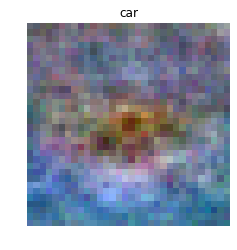

In [391]:
w = best_logistic.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 1)
w_min, w_max = np.min(w), np.max(w)
classes = ['car']
for i in range(1):
    plt.subplot(1, 2, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

Explain the possible reasons for the differences in the visualization of the weights in the both cases.

Your answer here

Bonus (**10 points**): Regularization is a very important technique in machine learning to prevent overfitting. Mathematically speaking, it adds a regularization term to the loss to penalize larger weights. For this part, implement L2 regularization of the form:
$$
Loss = Loss + \lambda \cdot \sum_{i=0}^k w_k^2
$$
Where $\lambda$ is yet another hyper parameter. Search for an optimal $\lambda$ (look around 5e4) and don't forget to update the gradient or the regularization won't effect the weights. When you are finished, train a perceptron classifier and visualize the weights. What do you see?

In [ ]:
### Your code here ###